In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score

**Explorartory Data Analysis**

In [54]:
#see % of missing data for each column
laps_aggregated = pd.read_csv("race_data_for_rf.csv")
#laps_aggregated["LapTime"] = pd.to_timedelta(laps_aggregated["LapTime"]).dt.total_seconds()
print(laps_aggregated.describe())
laps_aggregated.isna().mean().sort_values(ascending=False).head(10)

              Year  DriverNumber  TotalLapsCompleted     TyreLife  \
count  2791.000000   2791.000000         2791.000000  2791.000000   
mean   2022.104980     28.649588           56.120745    31.276603   
std       2.018573     25.150994           14.887972    10.587753   
min    2019.000000      1.000000            1.000000     1.000000   
25%    2020.000000     10.000000           52.000000    25.000000   
50%    2022.000000     20.000000           57.000000    31.000000   
75%    2024.000000     44.000000           67.500000    37.000000   
max    2025.000000     99.000000           87.000000    78.000000   

       RegulationEra      LapTime  Mean_SpeedI1  Mean_SpeedI2  Mean_SpeedFL  \
count    2791.000000  2791.000000   2790.000000   2791.000000   2779.000000   
mean        0.599427    94.606832    253.400498    246.567431    261.519989   
std         0.490102    16.518730     45.087655     40.980114     35.458551   
min         0.000000    62.932345    100.580000     95.000000 

Mean_SpeedFL          0.004300
FinalStintCompound    0.002150
Mean_SpeedI1          0.000358
Mean_SpeedI2          0.000000
FinalPosition         0.000000
Overtakes_Per_Race    0.000000
Mean_TrackStatus      0.000000
Mean_Humidity         0.000000
Mean_WindSpeed        0.000000
Mean_TrackTemp        0.000000
dtype: float64

In [55]:
laps_aggregated.dtypes

Year                    int64
RaceName               object
Driver                 object
DriverNumber            int64
TotalLapsCompleted      int64
IsPersonalBest           bool
TyreLife              float64
RegulationEra           int64
LapTime               float64
FinalStintCompound     object
Team                   object
Mean_SpeedI1          float64
Mean_SpeedI2          float64
Mean_SpeedFL          float64
Mean_SpeedST          float64
Mean_AirTemp          float64
Mean_TrackTemp        float64
Mean_WindSpeed        float64
Mean_Humidity         float64
Mean_TrackStatus      float64
Overtakes_Per_Race      int64
FinalPosition           int64
FinalRaceTime         float64
dtype: object

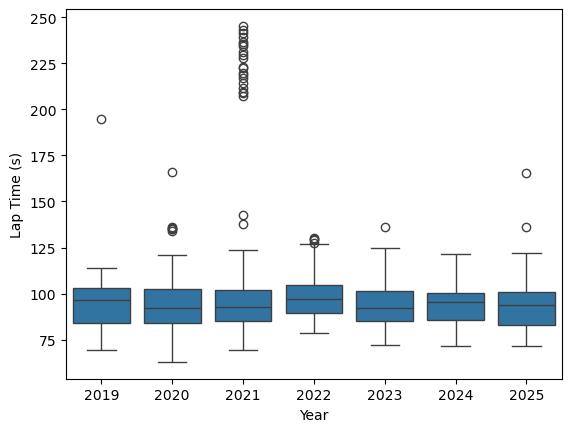

In [56]:
#check for outliers in laptime
sns.boxplot(x='Year', y='LapTime', data=laps_aggregated)
plt.ylabel("Lap Time (s)")
plt.show()

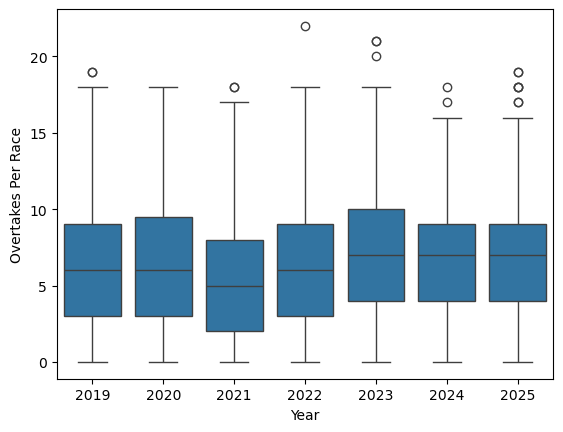

In [57]:
sns.boxplot(x='Year', y='Overtakes_Per_Race', data=laps_aggregated)
plt.ylabel("Overtakes Per Race")
plt.show()

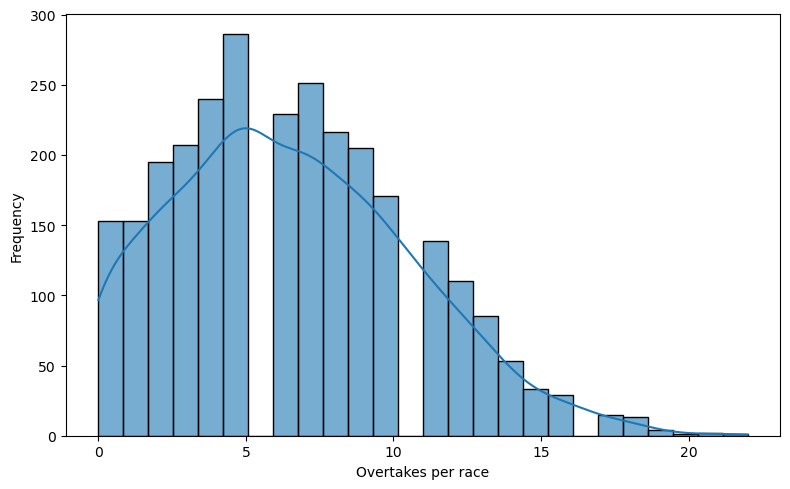

In [58]:
plt.figure(figsize=(8,5))
sns.histplot(laps_aggregated['Overtakes_Per_Race'], kde=True, color='tab:blue', alpha=0.6)
plt.xlabel("Overtakes per race")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

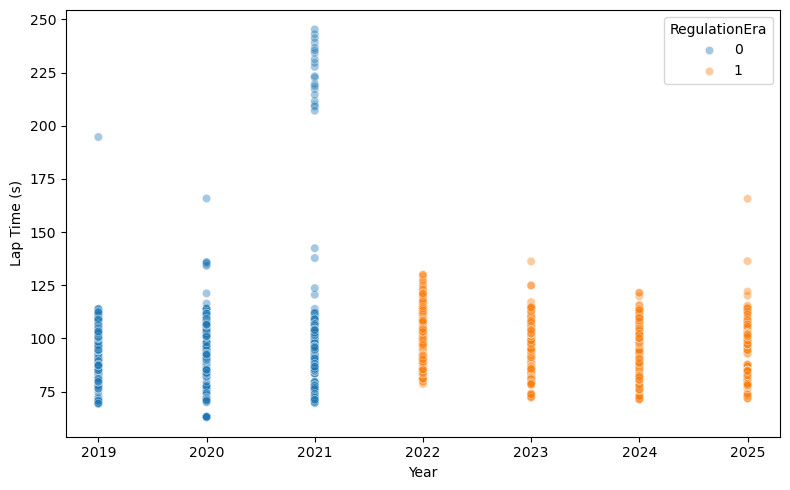

In [24]:
#plot distribution of laptime pre & post regulation
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=laps_aggregated,
    x='Year',
    y='LapTime',
    hue='RegulationEra',
    alpha=0.4
)

plt.xlabel("Year")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

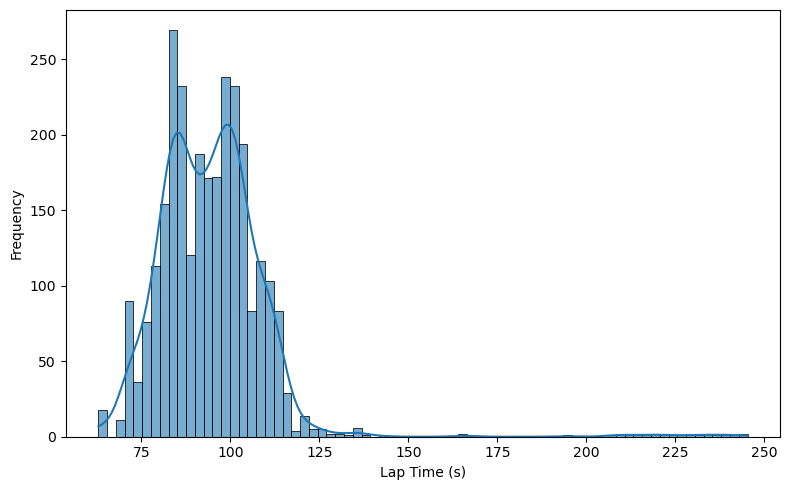

In [25]:
#plot distribution of lap time
plt.figure(figsize=(8,5))
sns.histplot(laps_aggregated['LapTime'], kde=True, color='tab:blue', alpha=0.6)
plt.xlabel("Lap Time (s)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

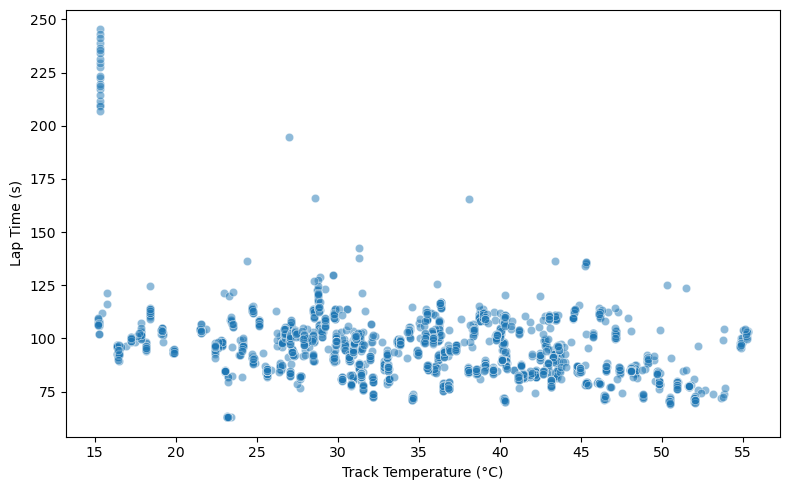

In [26]:
#compare laptime with tracktemp
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=laps_aggregated,
    x='Mean_TrackTemp',
    y='LapTime',
    alpha=0.5
)
plt.xlabel("Track Temperature (°C)")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

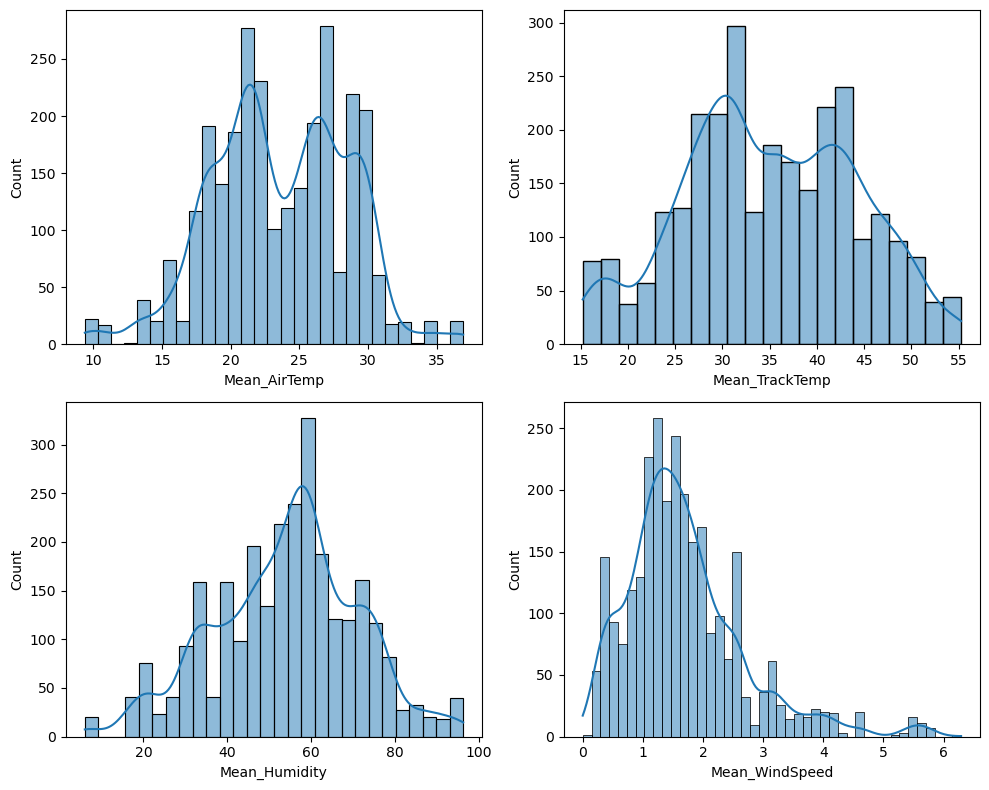

In [27]:
#weather variable distributions
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.histplot(laps_aggregated, x='Mean_AirTemp', ax=axes[0,0], kde=True)
sns.histplot(laps_aggregated, x='Mean_TrackTemp', ax=axes[0,1], kde=True)
sns.histplot(laps_aggregated, x='Mean_Humidity', ax=axes[1,0], kde=True)
sns.histplot(laps_aggregated, x='Mean_WindSpeed', ax=axes[1,1], kde=True)
plt.tight_layout()
plt.show()

**Checking Multicollinearity and VIF**

In [28]:
#isolate numerical cols and print correlation between numerical vars
numerical_df = laps_aggregated.select_dtypes(include=['number'])
corr_matrix = numerical_df.corr()
print(corr_matrix)


                        Year  DriverNumber  TotalLapsCompleted  TyreLife  \
Year                1.000000     -0.024782            0.043492 -0.001577   
DriverNumber       -0.024782      1.000000            0.021067  0.021254   
TotalLapsCompleted  0.043492      0.021067            1.000000  0.634189   
TyreLife           -0.001577      0.021254            0.634189  1.000000   
RegulationEra       0.870370     -0.042184            0.016947 -0.049923   
LapTime            -0.036521     -0.013715           -0.638519 -0.404109   
Mean_SpeedI1        0.035374      0.000671            0.110924  0.025867   
Mean_SpeedI2       -0.000313      0.008697            0.073742  0.067820   
Mean_SpeedFL        0.141608      0.005844            0.177943  0.166272   
Mean_SpeedST        0.105492     -0.016052            0.192991  0.168892   
Mean_AirTemp        0.064991     -0.005285            0.077964  0.047507   
Mean_TrackTemp      0.015264      0.001500            0.164370  0.148281   
Mean_WindSpe

**Random Forrest Classification**

In [ ]:
#build num & tgt cols
laps_aggregated = laps_aggregated[laps_aggregated['LapTime'] <= 150].copy()

target_column = 'RegulationEra'
categorical_features = ['Driver', 'FinalStintCompound']
numerical_features = ['LapTime','Mean_SpeedI1','Mean_SpeedI2','Mean_SpeedST','Mean_SpeedFL','Overtakes_Per_Race']

features_list = numerical_features + categorical_features
#missing data 
print(laps_aggregated[features_list + [target_column]].isnull().sum())
#set X,Y
X = laps_aggregated[features_list]
y = laps_aggregated[target_column]


#one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print("Shape of X after encoding:", X_encoded.shape)
print("Columns in X_encoded:", X_encoded.columns.tolist())

#split data, 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

#iitialize classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#fit model & run prediction
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

LapTime               0
Mean_SpeedI1          0
Mean_SpeedI2          0
Mean_SpeedST          0
Mean_SpeedFL          0
Overtakes_Per_Race    0
Driver                0
FinalStintCompound    0
RegulationEra         0
dtype: int64
Shape of X after encoding: (2768, 48)
Columns in X_encoded: ['LapTime', 'Mean_SpeedI1', 'Mean_SpeedI2', 'Mean_SpeedST', 'Mean_SpeedFL', 'Overtakes_Per_Race', 'Driver_ALB', 'Driver_ALO', 'Driver_ANT', 'Driver_BEA', 'Driver_BOR', 'Driver_BOT', 'Driver_COL', 'Driver_DEV', 'Driver_DOO', 'Driver_FIT', 'Driver_GAS', 'Driver_GIO', 'Driver_GRO', 'Driver_HAD', 'Driver_HAM', 'Driver_HUL', 'Driver_KUB', 'Driver_KVY', 'Driver_LAT', 'Driver_LAW', 'Driver_LEC', 'Driver_MAG', 'Driver_MAZ', 'Driver_MSC', 'Driver_NOR', 'Driver_OCO', 'Driver_PER', 'Driver_PIA', 'Driver_RAI', 'Driver_RIC', 'Driver_RUS', 'Driver_SAI', 'Driver_SAR', 'Driver_STR', 'Driver_TSU', 'Driver_VER', 'Driver_VET', 'Driver_ZHO', 'FinalStintCompound_INTERMEDIATE', 'FinalStintCompound_MEDIUM', 'FinalStintCompou

In [66]:
#version below now only uses speed related var
#also includes cross validation
laps_aggregated = pd.read_csv("race_data_for_rf.csv")

#redefine columns
target_column = 'RegulationEra'
categorical_features = ['Driver', 'FinalStintCompound']
speed_features = ['LapTime', 'Mean_SpeedI1', 'Mean_SpeedI2', 'Mean_SpeedST', 'Mean_SpeedFL']
numerical_features = speed_features
features_list = numerical_features + categorical_features

#handle na with imputation
for col in numerical_features:
    laps_aggregated[col].fillna(laps_aggregated[col].median(), inplace=True)
for col in categorical_features:
    laps_aggregated[col].fillna(laps_aggregated[col].mode()[0], inplace=True)

#one-hot encoding
X = laps_aggregated[features_list]
y = laps_aggregated[target_column]
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)


#split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

#initialize data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

#evlaute model
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} \n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


#Stratified 5-Fold crossval
# Define cross-validation strategy and scoring metrics
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=0)}

#cross validation for multiple metrics
cv_scores = {}
for metric_name, scorer in scoring.items():
    scores = cross_val_score(rf_classifier, X_encoded, y, cv=skf, scoring=scorer)
    cv_scores[metric_name] = scores

cv_df = pd.DataFrame(cv_scores)

print("Individual Fold Scores:")
print(cv_df)

#get summary statiscs
cv_summary = cv_df.agg(['mean', 'std']).T
cv_summary['Mean_Std'] = cv_summary.apply(lambda x: f"{x['mean']:.4f} +/- {x['std']:.4f}", axis=1)
print("\nCross-Validation Summary")
print(cv_summary[['Mean_Std']])

/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_11829/920096776.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps_aggregated[col].fillna(laps_aggregated[col].median(), inplace=True)
/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_11829/920096776.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

Training set size: 2232
Test set size: 559 

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       224
           1       0.86      0.94      0.90       335

    accuracy                           0.87       559
   macro avg       0.88      0.86      0.86       559
weighted avg       0.88      0.87      0.87       559


Confusion Matrix:
[[172  52]
 [ 19 316]]
Individual Fold Scores:
   accuracy  precision    recall  f1_score
0  0.874776   0.874726  0.874776  0.873794
1  0.876344   0.876436  0.876344  0.875316
2  0.865591   0.869472  0.865591  0.862890
3  0.869176   0.871991  0.869176  0.866853
4  0.869176   0.870181  0.869176  0.867494

Cross-Validation Summary
                    Mean_Std
accuracy   0.8710 +/- 0.0044
precision  0.8726 +/- 0.0030
recall     0.8710 +/- 0.0044
f1_score   0.8693 +/- 0.0052


/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_11829/3958928695.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


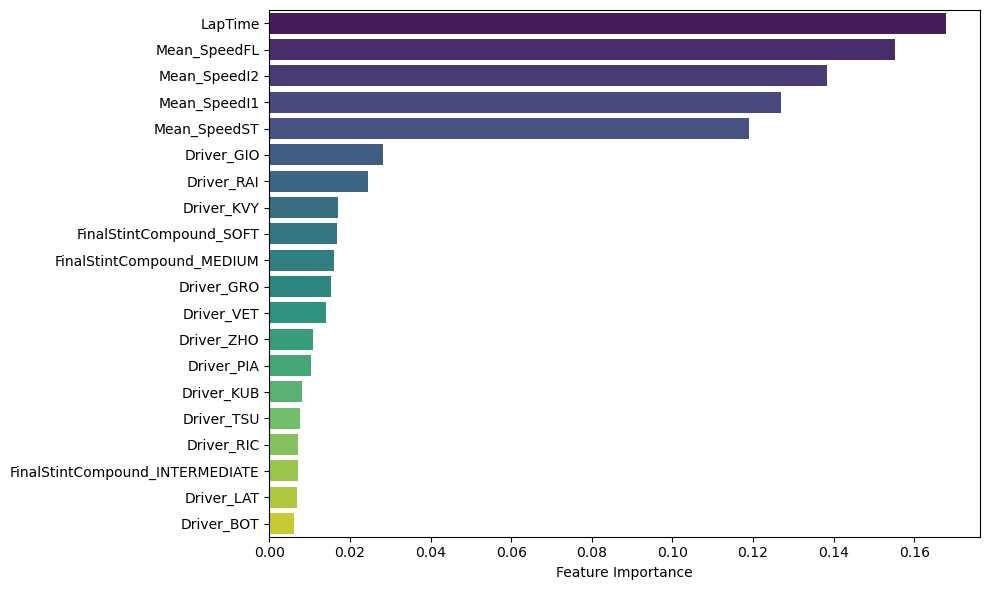

In [ ]:
#visualize feature importance
importances = rf_classifier.feature_importances_
feature_names = X_encoded.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

#plot features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance_df.head(20),
            palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

ROC AUC Score: 0.9467950426439232


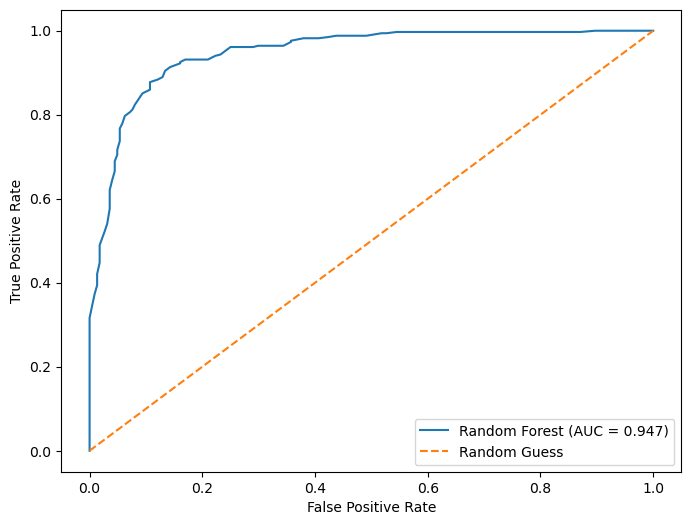

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#generat ROC curve
#get redicted probabilities 
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
#FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

#plot curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()